### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

def plot_combined_sirv_dynamics(excel_path, output_folder):
    # Load necessary sheets from the Excel file
    sirv_sheets = ['sus', 'infe', 'rec', 'vac']
    sirv_data = {sheet: pd.read_excel(excel_path, sheet_name=sheet) for sheet in sirv_sheets}

    sirv_proportions = []
    regions = sirv_data['sus']['Unnamed: 0'].values  # Region identifiers
    time_periods = range(1, sirv_data['sus'].shape[1])  # Exclude first column

    # Calculate SIRV proportions
    for idx, region in enumerate(regions):
        sus_row = sirv_data['sus'].iloc[idx, 1:].values
        infe_row = sirv_data['infe'].iloc[idx, 1:].values
        rec_row = sirv_data['rec'].iloc[idx, 1:].values
        vac_row = sirv_data['vac'].iloc[idx, 1:].values

        for t, (s, i, r, v) in enumerate(zip(sus_row, infe_row, rec_row, vac_row)):
            total_population = s + i + r + v
            if total_population > 0:
                sirv_proportions.append([region, t + 1, s / total_population, i / total_population, r / total_population, v / total_population])

    sirv_df = pd.DataFrame(sirv_proportions, columns=["Region", "TimePeriod", "S_Proportion", "I_Proportion", "R_Proportion", "V_Proportion"])

    # Create a 23x3 grid plot
    fig, axes = plt.subplots(23, 3, figsize=(15, 60), sharex=True, sharey=True)
    fig.suptitle("SIRV Dynamics Across All Regions", fontsize=16, y=0.92)

    for idx, region in enumerate(sirv_df["Region"].unique()):
        row, col = divmod(idx, 3)
        region_data = sirv_df[sirv_df["Region"] == region]
        ax = axes[row, col]
        
        ax.plot(region_data["TimePeriod"], region_data["S_Proportion"], label="S", color="blue")
        ax.plot(region_data["TimePeriod"], region_data["I_Proportion"], label="I", color="red")
        ax.plot(region_data["TimePeriod"], region_data["R_Proportion"], label="R", color="green")
        ax.plot(region_data["TimePeriod"], region_data["V_Proportion"], label="V", color="orange")
        ax.set_title(f"Region {region}", fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(False)

    # Adjust layout and save
    fig.tight_layout(rect=[0, 0.03, 1, 0.9])
    combined_plot_path = os.path.join(output_folder, "combined_sirv_dynamics.png")
    plt.savefig(combined_plot_path, bbox_inches="tight")
    print(f"Combined SIRV dynamics plot saved to '{combined_plot_path}'")
    plt.show()


def plot_total_unmet_demand(excel_path, output_folder):
    # Load the 'u' sheet from the Excel file
    u_data = pd.read_excel(excel_path, sheet_name='u')

    # Sum unmet demand across all regions for each time period
    time_periods = u_data.columns[1:]  # Exclude the first column (region identifier)
    total_unmet_demand = u_data.iloc[:, 1:].sum(axis=0)  # Sum over all regions for each time period

    # Plot total unmet demand over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_periods, total_unmet_demand, marker='o', linestyle='-', color='r')
    plt.title("Total Unmet Demand Over Time")
    plt.xlabel("Time Period")
    plt.ylabel("Total Unmet Demand")
    plt.grid(True)

    # Save plot
    plot_path = os.path.join(output_folder, "total_unmet_demand.png")
    plt.savefig(plot_path)
    print(f"Total unmet demand plot saved to '{plot_path}'")
    plt.show()


Combined SIRV dynamics plot saved to 'results558Data\combined_sirv_dynamics.png'


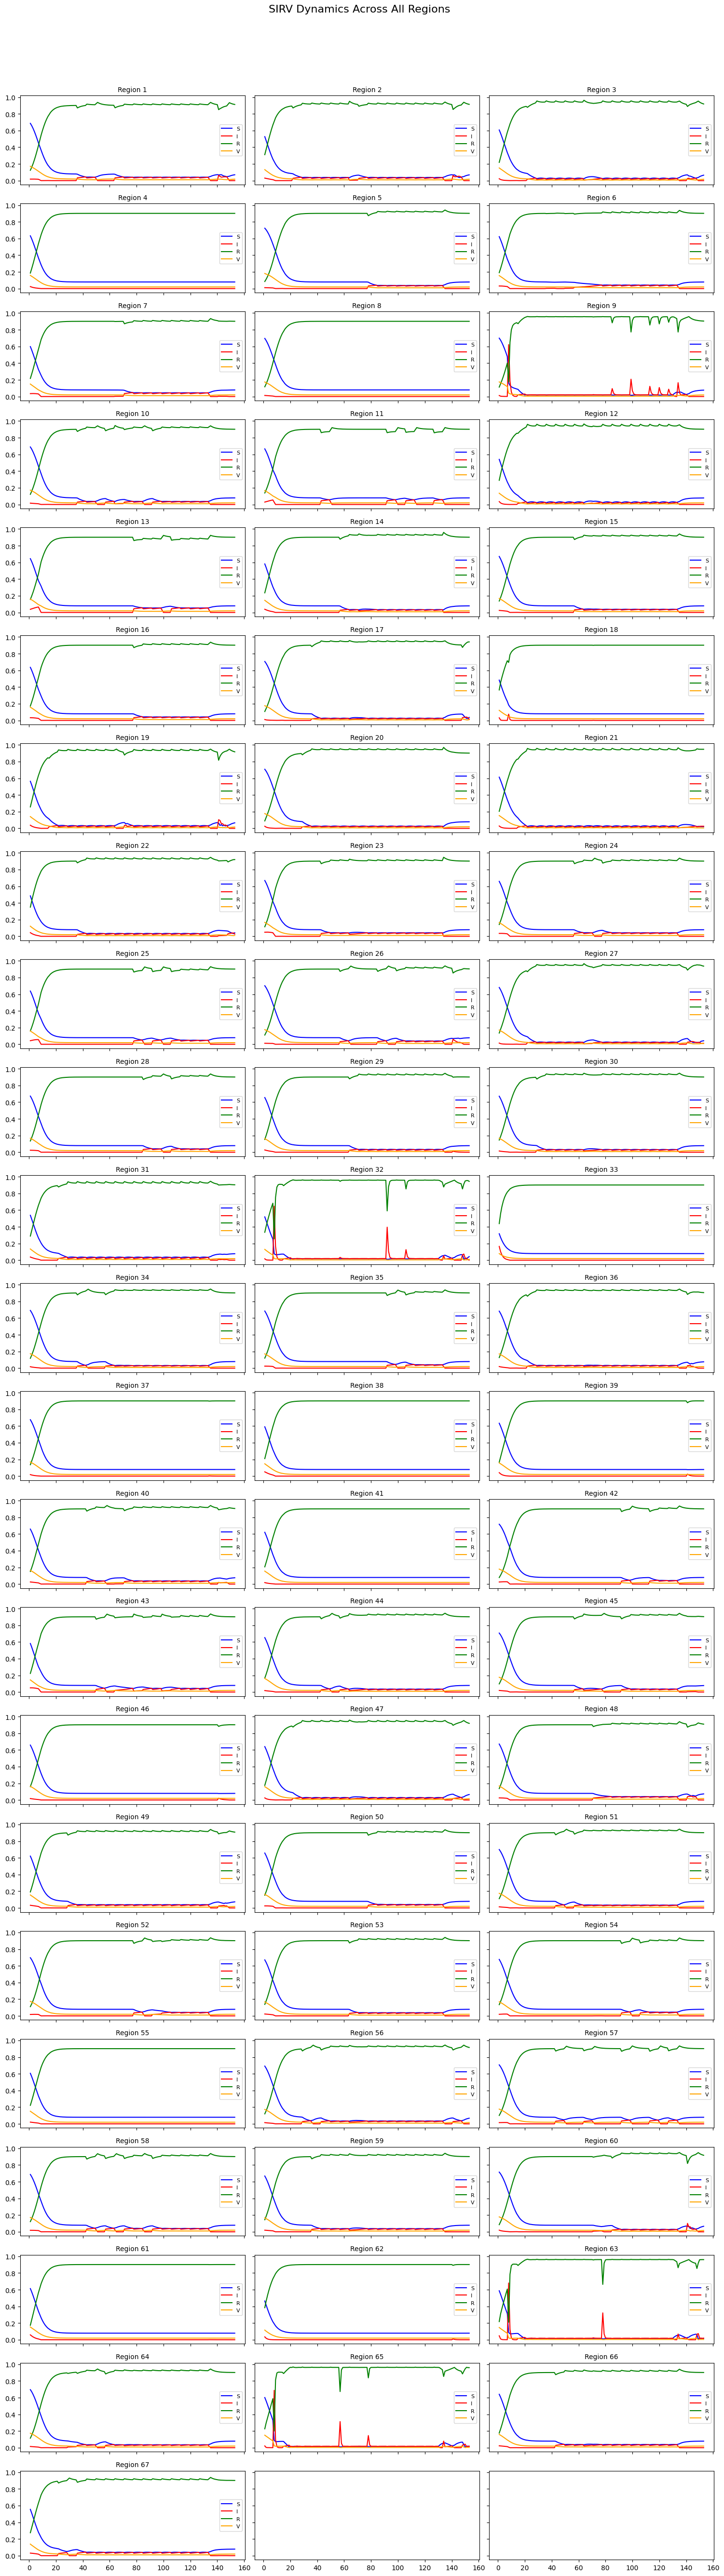

Total unmet demand plot saved to 'results558Data\total_unmet_demand.png'


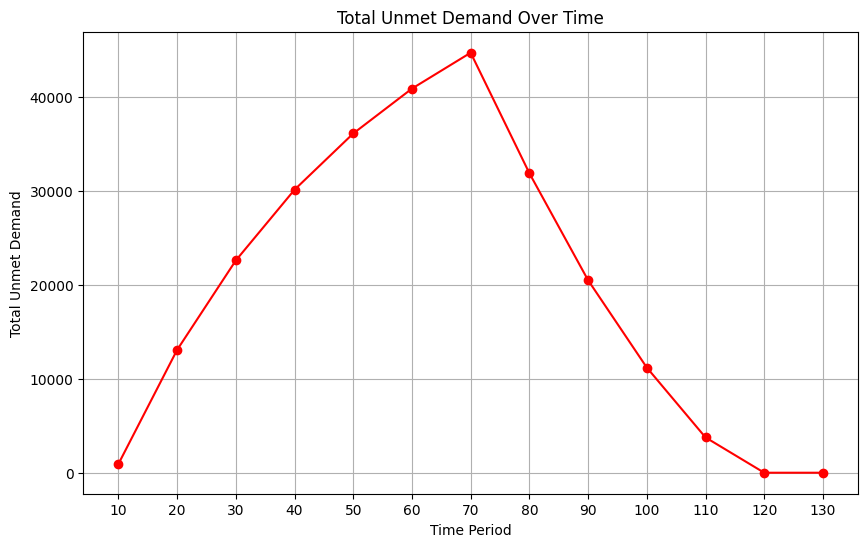

In [3]:
# File path to the Excel sheet
excel_file = "outputData\\results558.xlsx"
output_folder = "results558Data"
os.makedirs(output_folder, exist_ok=True)

# Plot SIRV dynamics in a combined 23x3 grid
plot_combined_sirv_dynamics(excel_file, output_folder)

# Plot total unmet demand
plot_total_unmet_demand(excel_file, output_folder)
